# 03 - Análise de Grafos de Xadrez

Este notebook analisa propriedades e estatísticas dos grafos de xadrez.

## Objetivos
1. Analisar propriedades topológicas dos grafos
2. Calcular métricas de centralidade
3. Identificar padrões e estruturas
4. Preparar features para GNNs

## Métricas Analisadas
- **Centralidade**: Degree, Betweenness, Closeness, Eigenvector
- **Conectividade**: Densidade, Clustering, Path Length
- **Estrutura**: Communities, Motifs, Subgraphs

## Importações e Configurações


In [25]:
# Importações necessárias
import sys
import os
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from typing import List, Dict, Tuple
import pickle
import warnings
from collections import defaultdict, Counter
import time
warnings.filterwarnings('ignore')

# Importar ChessGraph class para resolver o erro de pickle
try:
    from data import ChessGraph
    print("ChessGraph importado do módulo data")
except ImportError:
    print("ChessGraph não encontrado no módulo. Definindo classe localmente...")
    
    # Definir ChessGraph localmente para resolver o erro de pickle
    class ChessGraph:
        """Representa um grafo de posição de xadrez"""
        
        def __init__(self, board_fen: str, graph_type: str = "attack"):
            self.board_fen = board_fen
            self.graph_type = graph_type
            self.nodes = []
            self.edges = []
            self.node_features = {}
            self.edge_features = {}
            self.networkx_graph = nx.Graph()
        
        def to_networkx(self):
            """Converte para NetworkX Graph"""
            G = nx.Graph()
            
            # Adicionar nós
            for node in self.nodes:
                G.add_node(node, **self.node_features.get(node, {}))
            
            # Adicionar arestas
            for edge in self.edges:
                G.add_edge(edge[0], edge[1], **self.edge_features.get(edge, {}))
            
            return G

# Configuração de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Bibliotecas importadas com sucesso!")

ChessGraph importado do módulo data
Bibliotecas importadas com sucesso!


In [26]:
# Carregar dados processados
def load_processed_data(filename='constructed_graphs.pkl'):
    """Carrega grafos processados"""
    try:
        with open(f'../data/{filename}', 'rb') as f:
            return pickle.load(f)
    except AttributeError as e:
        if "Can't get attribute 'ChessGraph'" in str(e):
            print("Erro de pickle detectado. Tentando carregar com classe local...")
            # Tentar carregar com a classe local definida
            import sys
            sys.modules['__main__'].ChessGraph = ChessGraph
            with open(f'../data/{filename}', 'rb') as f:
                return pickle.load(f)
        else:
            raise e
    except FileNotFoundError:
        print(f"Arquivo {filename} não encontrado. Execute primeiro o notebook 02_graph_construction.ipynb")
        return None

# Carregar grafos
chess_graphs = load_processed_data()
if chess_graphs:
    print(f"Grafos carregados:")
    for graph_type, graphs in chess_graphs.items():
        print(f"  {graph_type}: {len(graphs)} grafos")
else:
    print("Grafos não encontrados. Criando dados de exemplo...")
    # Criar dados de exemplo
    chess_graphs = {
        'attack': [],
        'defense': [],
        'movement': [],
        'hybrid': []
    }

Grafos carregados:
  attack: 1500 grafos
  defense: 1500 grafos
  movement: 1500 grafos
  hybrid: 1500 grafos


In [27]:
chess_graphs['attack'][0]

In [28]:
# Análise de Centralidade
def analyze_centrality_metrics(graphs):
    """Analisa métricas de centralidade dos grafos"""
    print("=== ANÁLISE DE CENTRALIDADE ===")
    
    centrality_results = {}
    
    for graph_type, graph_list in graphs.items():
        if not graph_list:
            continue
            
        print(f"\n📊 CENTRALIDADE - {graph_type.upper()}:")
        
        # Métricas de centralidade
        degree_centrality = []
        betweenness_centrality = []
        closeness_centrality = []
        eigenvector_centrality = []
        
        for graph in graph_list:
            nx_graph = graph.to_networkx()
            
            if len(nx_graph.nodes()) > 0:
                # Degree Centrality
                degree_cent = nx.degree_centrality(nx_graph)
                degree_centrality.extend(list(degree_cent.values()))
                
                # Betweenness Centrality
                betweenness_cent = nx.betweenness_centrality(nx_graph)
                betweenness_centrality.extend(list(betweenness_cent.values()))
                
                # Closeness Centrality
                try:
                    closeness_cent = nx.closeness_centrality(nx_graph)
                    closeness_centrality.extend(list(closeness_cent.values()))
                except:
                    pass
                
                # Eigenvector Centrality
                try:
                    eigenvector_cent = nx.eigenvector_centrality(nx_graph, max_iter=1000)
                    eigenvector_centrality.extend(list(eigenvector_cent.values()))
                except:
                    pass
        
        # Estatísticas
        if degree_centrality:
            print(f"  Degree Centrality - Média: {np.mean(degree_centrality):.3f}, Std: {np.std(degree_centrality):.3f}")
        if betweenness_centrality:
            print(f"  Betweenness Centrality - Média: {np.mean(betweenness_centrality):.3f}, Std: {np.std(betweenness_centrality):.3f}")
        if closeness_centrality:
            print(f"  Closeness Centrality - Média: {np.mean(closeness_centrality):.3f}, Std: {np.std(closeness_centrality):.3f}")
        if eigenvector_centrality:
            print(f"  Eigenvector Centrality - Média: {np.mean(eigenvector_centrality):.3f}, Std: {np.std(eigenvector_centrality):.3f}")
        
        centrality_results[graph_type] = {
            'degree': degree_centrality,
            'betweenness': betweenness_centrality,
            'closeness': closeness_centrality,
            'eigenvector': eigenvector_centrality
        }
    
    return centrality_results

# Analisar centralidade
centrality_results = analyze_centrality_metrics(chess_graphs)

=== ANÁLISE DE CENTRALIDADE ===

📊 CENTRALIDADE - ATTACK:
  Degree Centrality - Média: 0.004, Std: 0.017
  Betweenness Centrality - Média: 0.000, Std: 0.002
  Closeness Centrality - Média: 0.005, Std: 0.020
  Eigenvector Centrality - Média: 0.149, Std: 0.140

📊 CENTRALIDADE - DEFENSE:
  Degree Centrality - Média: 0.000, Std: 0.003
  Betweenness Centrality - Média: 0.000, Std: 0.000
  Closeness Centrality - Média: 0.000, Std: 0.003
  Eigenvector Centrality - Média: 0.194, Std: 0.065

📊 CENTRALIDADE - MOVEMENT:
  Degree Centrality - Média: 0.011, Std: 0.021
  Betweenness Centrality - Média: 0.003, Std: 0.015
  Closeness Centrality - Média: 0.029, Std: 0.050
  Eigenvector Centrality - Média: 0.061, Std: 0.109

📊 CENTRALIDADE - HYBRID:
  Degree Centrality - Média: 0.027, Std: 0.040
  Betweenness Centrality - Média: 0.011, Std: 0.038
  Closeness Centrality - Média: 0.069, Std: 0.085
  Eigenvector Centrality - Média: 0.089, Std: 0.132


In [29]:
# Análise de Conectividade
def analyze_connectivity_metrics(graphs):
    """Analisa métricas de conectividade dos grafos"""
    print("\n=== ANÁLISE DE CONECTIVIDADE ===")
    
    connectivity_results = {}
    
    for graph_type, graph_list in graphs.items():
        if not graph_list:
            continue
            
        print(f"\n🔗 CONECTIVIDADE - {graph_type.upper()}:")
        
        # Métricas de conectividade
        densities = []
        clustering_coeffs = []
        path_lengths = []
        diameters = []
        num_components = []
        
        for graph in graph_list:
            nx_graph = graph.to_networkx()
            
            if len(nx_graph.nodes()) > 0:
                # Densidade
                density = nx.density(nx_graph)
                densities.append(density)
                
                # Clustering Coefficient
                try:
                    clustering = nx.average_clustering(nx_graph)
                    clustering_coeffs.append(clustering)
                except:
                    pass
                
                # Path Length (apenas para grafos conectados)
                try:
                    if nx.is_connected(nx_graph):
                        path_length = nx.average_shortest_path_length(nx_graph)
                        path_lengths.append(path_length)
                        
                        diameter = nx.diameter(nx_graph)
                        diameters.append(diameter)
                except:
                    pass
                
                # Número de componentes conectados
                num_comp = nx.number_connected_components(nx_graph)
                num_components.append(num_comp)
        
        # Estatísticas
        if densities:
            print(f"  Densidade - Média: {np.mean(densities):.3f}, Min: {min(densities):.3f}, Max: {max(densities):.3f}")
        if clustering_coeffs:
            print(f"  Clustering - Média: {np.mean(clustering_coeffs):.3f}, Min: {min(clustering_coeffs):.3f}, Max: {max(clustering_coeffs):.3f}")
        if path_lengths:
            print(f"  Path Length - Média: {np.mean(path_lengths):.3f}, Min: {min(path_lengths):.3f}, Max: {max(path_lengths):.3f}")
        if diameters:
            print(f"  Diâmetro - Média: {np.mean(diameters):.1f}, Min: {min(diameters)}, Max: {max(diameters)}")
        if num_components:
            print(f"  Componentes - Média: {np.mean(num_components):.1f}, Min: {min(num_components)}, Max: {max(num_components)}")
        
        connectivity_results[graph_type] = {
            'density': densities,
            'clustering': clustering_coeffs,
            'path_length': path_lengths,
            'diameter': diameters,
            'components': num_components
        }
    
    return connectivity_results

# Analisar conectividade
connectivity_results = analyze_connectivity_metrics(chess_graphs)



=== ANÁLISE DE CONECTIVIDADE ===

🔗 CONECTIVIDADE - ATTACK:
  Densidade - Média: 0.005, Min: 0.000, Max: 0.167
  Clustering - Média: 0.000, Min: 0.000, Max: 0.000
  Componentes - Média: 23.0, Min: 2, Max: 32

🔗 CONECTIVIDADE - DEFENSE:
  Densidade - Média: 0.000, Min: 0.000, Max: 0.010
  Clustering - Média: 0.000, Min: 0.000, Max: 0.000
  Componentes - Média: 23.9, Min: 2, Max: 32

🔗 CONECTIVIDADE - MOVEMENT:
  Densidade - Média: 0.011, Min: 0.000, Max: 0.028
  Clustering - Média: 0.000, Min: 0.000, Max: 0.000
  Componentes - Média: 43.7, Min: 15, Max: 64

🔗 CONECTIVIDADE - HYBRID:
  Densidade - Média: 0.027, Min: 0.000, Max: 0.214
  Clustering - Média: 0.002, Min: 0.000, Max: 0.106
  Componentes - Média: 19.1, Min: 2, Max: 30


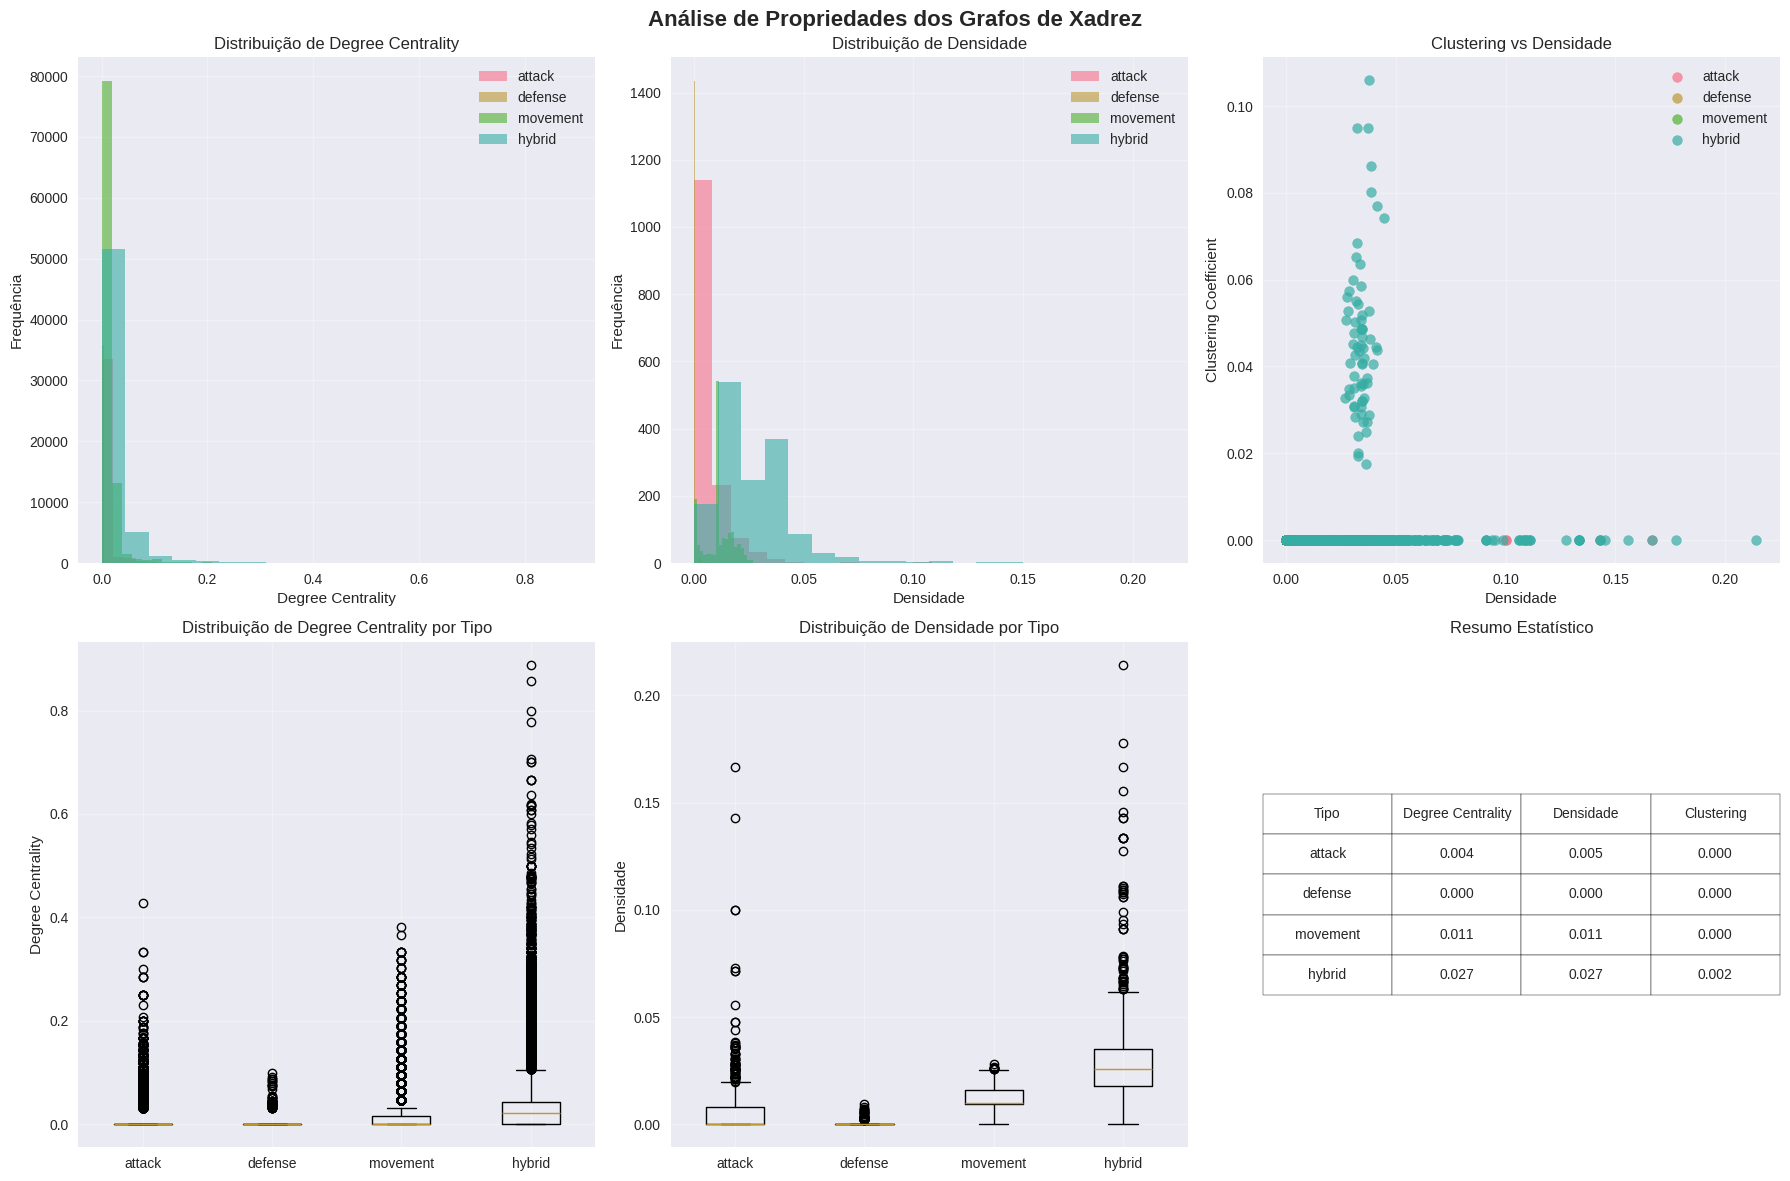

In [30]:
# Visualização das Análises
def create_analysis_visualizations(centrality_results, connectivity_results):
    """Cria visualizações das análises de grafos"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Análise de Propriedades dos Grafos de Xadrez', fontsize=16, fontweight='bold')
    
    # 1. Distribuição de Centralidade
    ax1 = axes[0, 0]
    for graph_type, metrics in centrality_results.items():
        if metrics['degree']:
            ax1.hist(metrics['degree'], alpha=0.6, label=f'{graph_type}', bins=20)
    ax1.set_title('Distribuição de Degree Centrality')
    ax1.set_xlabel('Degree Centrality')
    ax1.set_ylabel('Frequência')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribuição de Densidade
    ax2 = axes[0, 1]
    for graph_type, metrics in connectivity_results.items():
        if metrics['density']:
            ax2.hist(metrics['density'], alpha=0.6, label=f'{graph_type}', bins=20)
    ax2.set_title('Distribuição de Densidade')
    ax2.set_xlabel('Densidade')
    ax2.set_ylabel('Frequência')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Clustering vs Densidade
    ax3 = axes[0, 2]
    for graph_type, metrics in connectivity_results.items():
        if metrics['density'] and metrics['clustering']:
            ax3.scatter(metrics['density'], metrics['clustering'], 
                       label=f'{graph_type}', alpha=0.7, s=50)
    ax3.set_title('Clustering vs Densidade')
    ax3.set_xlabel('Densidade')
    ax3.set_ylabel('Clustering Coefficient')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Box plot de Centralidade
    ax4 = axes[1, 0]
    centrality_data = []
    centrality_labels = []
    for graph_type, metrics in centrality_results.items():
        if metrics['degree']:
            centrality_data.append(metrics['degree'])
            centrality_labels.append(graph_type)
    
    if centrality_data:
        ax4.boxplot(centrality_data, labels=centrality_labels)
        ax4.set_title('Distribuição de Degree Centrality por Tipo')
        ax4.set_ylabel('Degree Centrality')
        ax4.grid(True, alpha=0.3)
    
    # 5. Box plot de Densidade
    ax5 = axes[1, 1]
    density_data = []
    density_labels = []
    for graph_type, metrics in connectivity_results.items():
        if metrics['density']:
            density_data.append(metrics['density'])
            density_labels.append(graph_type)
    
    if density_data:
        ax5.boxplot(density_data, labels=density_labels)
        ax5.set_title('Distribuição de Densidade por Tipo')
        ax5.set_ylabel('Densidade')
        ax5.grid(True, alpha=0.3)
    
    # 6. Resumo Estatístico
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Criar tabela de resumo
    summary_data = []
    for graph_type in centrality_results.keys():
        if graph_type in connectivity_results:
            centrality = centrality_results[graph_type]
            connectivity = connectivity_results[graph_type]
            
            summary_data.append([
                graph_type,
                f"{np.mean(centrality['degree']):.3f}" if centrality['degree'] else "N/A",
                f"{np.mean(connectivity['density']):.3f}" if connectivity['density'] else "N/A",
                f"{np.mean(connectivity['clustering']):.3f}" if connectivity['clustering'] else "N/A"
            ])
    
    if summary_data:
        table = ax6.table(cellText=summary_data,
                         colLabels=['Tipo', 'Degree Centrality', 'Densidade', 'Clustering'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        ax6.set_title('Resumo Estatístico')
    
    plt.tight_layout()
    plt.show()

# Criar visualizações
create_analysis_visualizations(centrality_results, connectivity_results)


In [31]:
# Análise de Padrões e Estruturas
def analyze_graph_patterns(graphs):
    """Analisa padrões e estruturas nos grafos"""
    print("\n=== ANÁLISE DE PADRÕES E ESTRUTURAS ===")
    
    pattern_results = {}
    
    for graph_type, graph_list in graphs.items():
        if not graph_list:
            continue
            
        print(f"\n🔍 PADRÕES - {graph_type.upper()}:")
        
        # Análise de grau
        degree_distributions = []
        degree_sequences = []
        
        # Análise de triângulos
        triangle_counts = []
        
        # Análise de caminhos
        path_lengths = []
        
        for graph in graph_list:
            nx_graph = graph.to_networkx()
            
            if len(nx_graph.nodes()) > 0:
                # Distribuição de grau
                degrees = [d for n, d in nx_graph.degree()]
                degree_distributions.extend(degrees)
                degree_sequences.append(degrees)
                
                # Contar triângulos
                try:
                    triangles = sum(nx.triangles(nx_graph).values()) // 3
                    triangle_counts.append(triangles)
                except:
                    pass
                
                # Análise de caminhos
                try:
                    if nx.is_connected(nx_graph):
                        all_paths = dict(nx.all_pairs_shortest_path_length(nx_graph))
                        path_lengths.extend([length for paths in all_paths.values() 
                                           for length in paths.values() if length > 0])
                except:
                    pass
        
        # Estatísticas
        if degree_distributions:
            print(f"  Grau - Média: {np.mean(degree_distributions):.1f}, Min: {min(degree_distributions)}, Max: {max(degree_distributions)}")
            print(f"  Grau - Desvio padrão: {np.std(degree_distributions):.1f}")
        
        if triangle_counts:
            print(f"  Triângulos - Média: {np.mean(triangle_counts):.1f}, Min: {min(triangle_counts)}, Max: {max(triangle_counts)}")
        
        if path_lengths:
            print(f"  Caminhos - Média: {np.mean(path_lengths):.1f}, Min: {min(path_lengths)}, Max: {max(path_lengths)}")
        
        pattern_results[graph_type] = {
            'degrees': degree_distributions,
            'triangles': triangle_counts,
            'paths': path_lengths
        }
    
    return pattern_results

# Analisar padrões
pattern_results = analyze_graph_patterns(chess_graphs)



=== ANÁLISE DE PADRÕES E ESTRUTURAS ===

🔍 PADRÕES - ATTACK:
  Grau - Média: 0.1, Min: 0, Max: 5
  Grau - Desvio padrão: 0.3
  Triângulos - Média: 0.0, Min: 0, Max: 0

🔍 PADRÕES - DEFENSE:
  Grau - Média: 0.0, Min: 0, Max: 2
  Grau - Desvio padrão: 0.1
  Triângulos - Média: 0.0, Min: 0, Max: 0

🔍 PADRÕES - MOVEMENT:
  Grau - Média: 0.7, Min: 0, Max: 24
  Grau - Desvio padrão: 1.3
  Triângulos - Média: 0.0, Min: 0, Max: 0

🔍 PADRÕES - HYBRID:
  Grau - Média: 1.1, Min: 0, Max: 24
  Grau - Desvio padrão: 1.5
  Triângulos - Média: 0.1, Min: 0, Max: 4


In [32]:
# Salvar Resultados da Análise
def save_analysis_results(centrality_results, connectivity_results, pattern_results, filename='graph_analysis_results.pkl'):
    """Salva resultados da análise de grafos"""
    output_path = f'../data/{filename}'
    
    # Criar diretório se não existir
    os.makedirs('../data', exist_ok=True)
    
    # Combinar todos os resultados
    analysis_results = {
        'centrality': centrality_results,
        'connectivity': connectivity_results,
        'patterns': pattern_results,
        'timestamp': time.time()
    }
    
    # Salvar resultados
    with open(output_path, 'wb') as f:
        pickle.dump(analysis_results, f)
    
    print(f"Resultados da análise salvos em: {output_path}")
    print(f"Tamanho do arquivo: {os.path.getsize(output_path) / (1024**2):.2f} MB")

# Salvar resultados
save_analysis_results(centrality_results, connectivity_results, pattern_results)

print("\n✅ Análise de grafos concluída e salva com sucesso!")
print("📁 Arquivos criados:")
print("  - ../data/graph_analysis_results.pkl")
print("\n🎯 Próximos passos:")
print("  - Execute o notebook 04_gnn_implementation.ipynb para implementar GNNs")
print("  - Use os resultados para treinar modelos de Graph Neural Networks")


Resultados da análise salvos em: ../data/graph_analysis_results.pkl
Tamanho do arquivo: 8.34 MB

✅ Análise de grafos concluída e salva com sucesso!
📁 Arquivos criados:
  - ../data/graph_analysis_results.pkl

🎯 Próximos passos:
  - Execute o notebook 04_gnn_implementation.ipynb para implementar GNNs
  - Use os resultados para treinar modelos de Graph Neural Networks
